# Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EmpiricalCovariance, LedoitWolf

import covariance_DRO

sns.set(rc={'figure.figsize':(8,4)})
sns.set(rc={"lines.linewidth":2.5})
sns.set_style("white")

import warnings
import time
#warnings.filterwarnings("ignore")

# Eigenvalue and Condition Number Path

In [2]:
def plot_ev_cn_path(eigs, method, epsilons = np.arange(0.1, 3, 0.1)):
    eigenvalues = []
    K = []
    sigma_hat = np.diag(eigs)
    for e in epsilons:
        sigma_star = covariance_DRO.estimate_cov(sigma_hat, e, method)
        w, v = np.linalg.eig(sigma_star)
        eigenvalues.append(w)
        K.append(w.max()/w.min())
    eigenvalues = np.vstack(eigenvalues)
    fig, axs = plt.subplots(1,2, figsize=(10,3.7))
    for i, e in enumerate(eigs):
        sns.lineplot(x=epsilons, y=eigenvalues[:,i], ax=axs[0])
        axs[0].set_title('Eigenvalue Path')
        axs[0].set_xlabel('Ball Radius')
        axs[0].set_ylabel('Eigenvalue')
    sns.lineplot(x=epsilons, y=K, ax=axs[1])
    axs[1].set_title('Condition Number Path')
    axs[1].set_xlabel('Ball Radius')
    axs[1].set_ylabel('Condition Number')
    sns.despine()
    return eigenvalues, K, axs

## Eigenvalues [1,2,3]

/Users/yvesrychener/Documents/PHD/Projects/CovariancePaper/covariance_DRO/python/covariance_DRO/optimizers.py:59: UserWarning: Result is on the left side of interval, which may indicate an incorrect interval.
  warn(


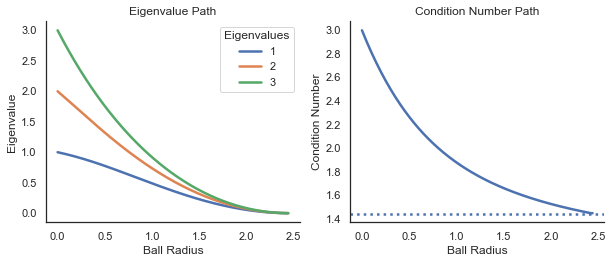

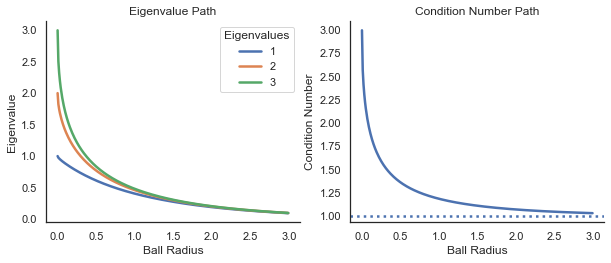

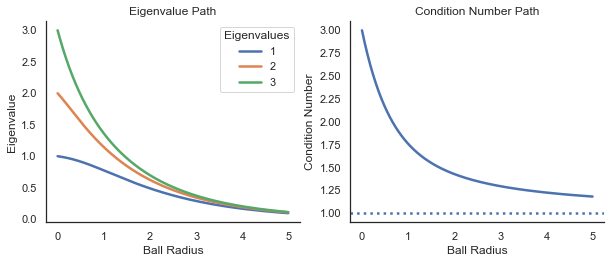

In [3]:
eigenvalues, K, axs = plot_ev_cn_path([1,2,3], 'Wasserstein', epsilons = np.arange(1e-6, np.sqrt(6), 0.01))
axs[1].axhline(np.cbrt(3),ls=':')
axs[0].legend(['1', '2', '3'], title = 'Eigenvalues')
#plt.suptitle('Wasserstein');
plt.savefig('plots/ws_123.pdf')

eigenvalues, K, axs = plot_ev_cn_path([1,2,3], 'KLdirect', epsilons = np.arange(1e-6, 3, 0.01))
axs[1].axhline(1,ls=':')
axs[0].legend(['1', '2', '3'], title = 'Eigenvalues')
#plt.suptitle('Kullback-Leibler');
plt.savefig('plots/kl_123.pdf')

eigenvalues, K, axs = plot_ev_cn_path([1,2,3], 'Fisher-Rao', epsilons = np.arange(1e-6, 5, 0.01))
axs[1].axhline(1,ls=':')
axs[0].legend(['1', '2', '3'], title = 'Eigenvalues')
#plt.suptitle('Fisher-Rao')
plt.savefig('plots/fr_123.pdf');

## Eigenvalues [2,3,10]

/Users/yvesrychener/Documents/PHD/Projects/CovariancePaper/covariance_DRO/python/covariance_DRO/optimizers.py:59: UserWarning: Result is on the left side of interval, which may indicate an incorrect interval.
  warn(


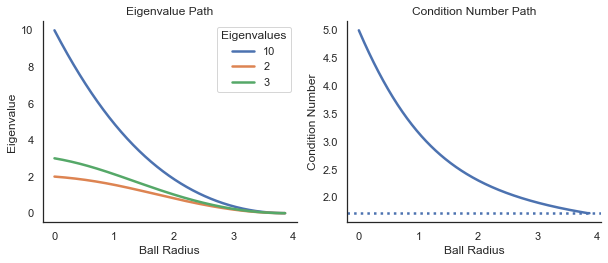

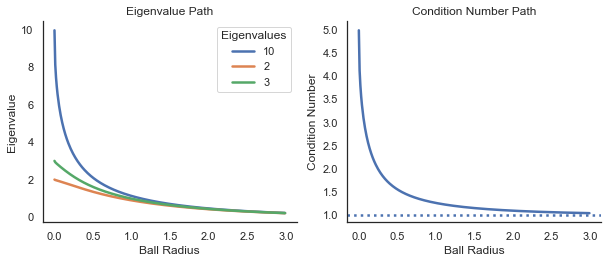

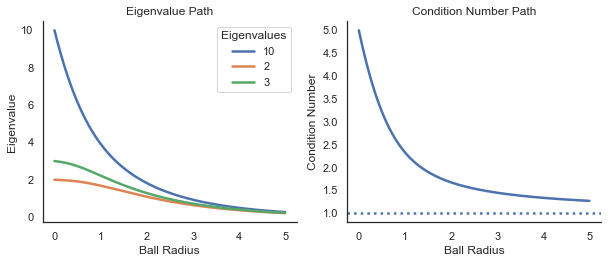

In [4]:
eigenvalues, K, axs = plot_ev_cn_path([10,2,3], 'Wasserstein', epsilons = np.arange(1e-6, np.sqrt(15), 0.01))
axs[0].legend(['10', '2', '3'], title = 'Eigenvalues')
axs[1].axhline(np.cbrt(10./2),ls=':')
#plt.suptitle('Wasserstein')
plt.savefig('plots/ws_1023.pdf');

eigenvalues, K, axs = plot_ev_cn_path([10,2,3], 'KLdirect', epsilons = np.arange(1e-6, 3, 0.01))
axs[0].legend(['10', '2', '3'], title = 'Eigenvalues')
axs[1].axhline(1,ls=':')
#plt.suptitle('Kullback-Leibler')
plt.savefig('plots/kl_1023.pdf')

eigenvalues, K, axs = plot_ev_cn_path([10,2,3], 'Fisher-Rao', epsilons = np.arange(1e-6, 5, 0.01))
axs[1].axhline(1,ls=':')
axs[0].legend(['10', '2', '3'], title = 'Eigenvalues')
#plt.suptitle('Fisher-Rao')
plt.savefig('plots/fr_1023.pdf');

# Computation Time

In [5]:
from scipy.stats import ortho_group
def generate_matrix(dims=100, h=10):
    S = np.diag([1]*int(dims*0.1)+[h]*int(dims*0.9))
    return S

## Change in computation time with Dimensionality

In [6]:
dimensions = [10, 50, 100, 500, 1000]
results = {}
for name in ['Wasserstein', 'KLdirect', 'Fisher-Rao']:
    method = lambda X: covariance_DRO.estimate_cov(sigma_hat, 0.2, name)
    times = []
    for d in dimensions:
        sigma_hat = generate_matrix(dims=d, h=5)
        s = time.time()
        _ = method(sigma_hat)
        times.append(time.time()-s)
    results[name] = times

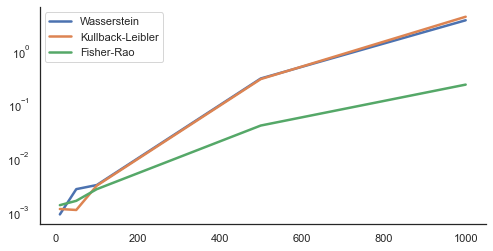

In [7]:
plt.semilogy(dimensions, results['Wasserstein'], label='Wasserstein')
plt.semilogy(dimensions, results['KLdirect'], label='Kullback-Leibler')
plt.semilogy(dimensions, results['Fisher-Rao'], label= 'Fisher-Rao')
sns.despine()
plt.legend()
plt.savefig('plots/compuation_time.pdf');

## Analysis of other effects

In [8]:
def test_method(epsilon, name, h):
    dimensions = [10, 50, 100, 500, 1000]
    method = lambda X: covariance_DRO.estimate_cov(sigma_hat, 0.2, 'Wasserstein')
    times = []
    for d in dimensions:
        sigma_hat = generate_matrix(dims=d, h=h)
        s = time.time()
        _ = method(sigma_hat)
        times.append(time.time()-s)
    return times

In [9]:
results = {}
for epsilon in [1e-2, 1e-1, 1, 10, 100]:
    for name in ['Wasserstein', 'KLdirect', 'Fisher-Rao']:
        for h in [5, 10, 50, 100, 500, 1000]:
            results.update({(epsilon, name, h):test_method(epsilon, name, h)})

In [10]:
def line_type(result):
    if result[1]=='Wasserstein':
        r = 'r'
    elif result[1]=='KLdirect':
        r = 'g'
    else:
        r = 'b'
    r += ['-', '--', '-.', ':'][int(np.log10(result[0]+2))]
    return r

### Dimensionality

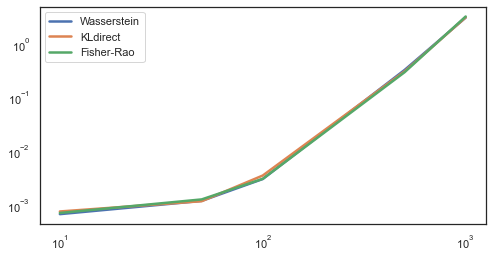

In [11]:
for result in results:
    if result[0]==1 and result[2]==10:
        plt.loglog([10, 50, 100, 500, 1000], results[result], 
                   label='{}'.format(result[1]))
        plt.legend()

### Original Condition Number

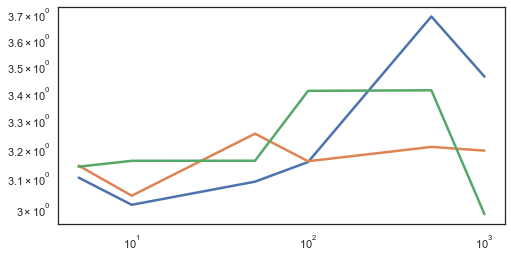

In [12]:
ws, kl, fr = [],[],[]
ws_x, kl_x, fr_x = [],[],[]
for result in results:
    if result[0]==1:
        if result[1]=='Wasserstein':
            ws.append(results[result][4])
            ws_x.append(result[2])
        elif result[1]=='KLdirect':
            kl.append(results[result][4])
            kl_x.append(result[2])
        else:
            fr.append(results[result][4])
            fr_x.append(result[2])
plt.loglog(ws_x, ws)
plt.loglog(kl_x, kl)
plt.loglog(fr_x, fr)

### Ball Radius

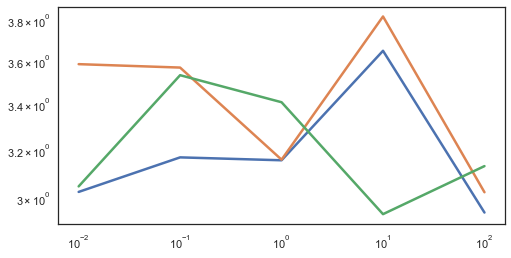

In [13]:
ws, kl, fr = [],[],[]
ws_x, kl_x, fr_x = [],[],[]
for result in results:
    if result[2]==100:
        if result[1]=='Wasserstein':
            ws.append(results[result][4])
            ws_x.append(result[0])
        elif result[1]=='KLdirect':
            kl.append(results[result][4])
            kl_x.append(result[0])
        else:
            fr.append(results[result][4])
            fr_x.append(result[0])
plt.loglog(ws_x, ws)
plt.loglog(kl_x, kl)
plt.loglog(fr_x, fr)